In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings("ignore")

def pprint(o):
    print(json.dumps(o, indent=2))

In [2]:
import rasa_nlu
import rasa_core
import spacy

### Intent and Entity Training

In [3]:
nlu_md = '''
## intent:greet
- hi
- hello
- hi, my name is [Jack](PERSON)
- hello, my name is [Jack](PERSON)
- hey

## intent:tax_due_dates
- When are property taxes due?
- When do I have to pay my taxes?
- tax due dates?
- where are taxes due?
- when do I pay taxes?
- are taxes due soon?
- find property tax due dates
- property tax due dates
- property taxes due
- how often do I have to pay my taxes?
- how many times do I pay taxes?
- when can I pay my taxes?
- when do I pay my taxes?
- when do I pay property taxes?

## intent:goodbye
- Bye
- goodbye
- peace
- later hater
- thank you, bye
- see you later
- see you soon

## intent:thankyou
- Thank you!
- thanks
- thank you
- I appreciate it
- gracias
'''

%store nlu_md > data/nlu_data.md

Writing 'nlu_md' (str) to file 'data/nlu_data.md'.


### Config

In [4]:
config = '''
language: "en"

pipeline:
- name: 'nlp_spacy'
- name: 'tokenizer_spacy'
- name: 'ner_spacy'
- name: 'intent_featurizer_spacy'
- name: 'intent_classifier_sklearn'
'''

%store config > nlu_config.yml

Writing 'config' (str) to file 'nlu_config.yml'.


### Train Rasa NLU Model

In [5]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

training_data = load_data("data/nlu_data.md")

trainer = Trainer(config.load("nlu_config.yml"))

interpreter = trainer.train(training_data)

model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of data/nlu_data.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 31 (4 distinct intents)
	- Found intents: 'goodbye', 'tax_due_dates', 'thankyou', 'greet'
	- entity examples: 2 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_classifier

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into 'C:\Users\vanguiano\Documents\Projects\conversational-interface\models\nlu\default\current'


### Single Test

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of data/nlu_data.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 31 (4 distinct intents)
	- Found intents: 'goodbye', 'tax_due_dates', 'thankyou', 'greet'
	- entity examples: 2 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 31 examples that have a defined intent out of 31 examples
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
               precision    recall  f1-score   support

      goodbye       1.00      1.00      1.00         7
        greet       1.00      1.00      1.00         5
tax_due_dates       1.00      1.00      1.00        14
     thankyou       1.00      1.

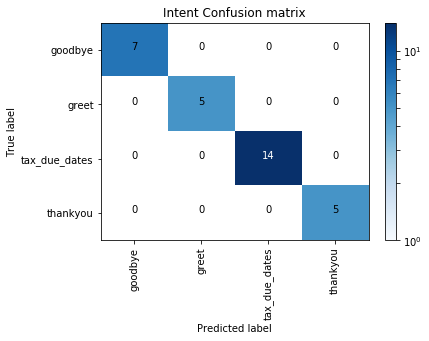

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_spacy 
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

     PERSON       1.00      1.00      1.00         2
  no_entity       1.00      1.00      1.00       124

avg / total       1.00      1.00      1.00       126



In [6]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("data/nlu_data.md", model_directory)

### Stories

In [7]:
stories = '''
## tax_due_dates_1
* greet
  - utter_greet
* tax_due_dates
  - action_request_info
* thankyou
  -utter_youre_welcome
* goodbye
  - utter_goodbye

## tax_due_dates_3
* greet
  - utter_greet
* goodbye
  - utter_goodbye

## tax_due_dates_4
* greet
  - utter_greet
* tax_due_dates
  - action_request_info
* goodbye
  - utter_goodbye
'''

%store stories > data/stories.md

Writing 'stories' (str) to file 'data/stories.md'.


### Domain

In [8]:
domain = '''
intents:
  - tax_due_dates
  - greet
  - goodbye
  - thankyou

actions:
  - utter_greet
  - utter_goodbye
  - utter_youre_welcome
  - actions.ActionRequestInfo

entities:
  - PERSON
  
slots:
  trial:
    type: text
  PERSON:
    type: text

templates:
  utter_greet:
    - "Hi!"
    - "Hello, {PERSON}!"
    - "Hi {PERSON}, it's great to hear from you!"
    - "Hey {PERSON}, how can I help you?"

  utter_goodbye:
    - "Bye!"
    - "I hope you had a good experience today!"
    - "See you soon!"
    - "Talk to you later!"
    - "Goodbye."

  utter_youre_welcome:
    - "You're welcome, {PERSON}!"
    - "No problem {PERSON}, I'm happy to help."
    - "You're welcome."
    - "No problem!"
'''

%store domain > domain.yml

Writing 'domain' (str) to file 'domain.yml'.


### Visualizing

In [9]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent("domain.yml")
agent.visualize("data/stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

INFO:apscheduler.scheduler:Scheduler started
C:\Users\vanguiano\Anaconda3\lib\site-packages\pykwalify\core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 185.38it/s, # trackers=1]


ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [22]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent("domain.yml", policies=[MemoizationPolicy(), KerasPolicy()])

training_data = agent.load_data("data/stories.md")

agent.train(
    training_data,
    validation_split = 0.0,
    epochs = 200)

agent.persist("models/dialogue")

C:\Users\vanguiano\Anaconda3\lib\site-packages\pykwalify\core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 144.71it/s, # trackers=4]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|████████████████████████████████████████████████| 38/38 [00:02<00:00, 13.44it/s, # actions=23]
INFO:rasa_core.featurizers:Created 23 action examples.
Processed actions: 23it [00:00, 159.31it/s, # examples=23]
INFO:rasa_core.policies.memoization:Memoriz

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, 5, 14)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
_________________________________________________________________
activation_4 (Activation)    (None, 7)                 0         
Total params: 6,247
Trainable params: 6,247
Non-trainable params: 0
_________________________________________________________________


INFO:rasa_core.policies.keras_policy:Fitting model with 23 total samples and a validation split of 0.0


Epoch 1/200
23/23 [==============================] - 2s 66ms/step - loss: 1.9344 - acc: 0.0870
Epoch 2/200
23/23 [==============================] - 0s 438us/step - loss: 1.9053 - acc: 0.1304
Epoch 3/200
23/23 [==============================] - 0s 353us/step - loss: 1.9142 - acc: 0.1739
Epoch 4/200
23/23 [==============================] - 0s 349us/step - loss: 1.8865 - acc: 0.3043
Epoch 5/200
23/23 [==============================] - 0s 583us/step - loss: 1.8861 - acc: 0.3913
Epoch 6/200
23/23 [==============================] - 0s 262us/step - loss: 1.8900 - acc: 0.3478
Epoch 7/200
23/23 [==============================] - 0s 475us/step - loss: 1.8544 - acc: 0.5652
Epoch 8/200
23/23 [==============================] - 0s 179us/step - loss: 1.8357 - acc: 0.4348
Epoch 9/200
23/23 [==============================] - 0s 0us/step - loss: 1.8377 - acc: 0.4783
Epoch 10/200
23/23 [==============================] - 0s 694us/step - loss: 1.8399 - acc: 0.5217
Epoch 11/200
23/23 [======================

Epoch 86/200
23/23 [==============================] - 0s 342us/step - loss: 1.2254 - acc: 0.5217
Epoch 87/200
23/23 [==============================] - 0s 398us/step - loss: 1.2581 - acc: 0.5217
Epoch 88/200
23/23 [==============================] - 0s 310us/step - loss: 1.2093 - acc: 0.5217
Epoch 89/200
23/23 [==============================] - 0s 280us/step - loss: 1.2392 - acc: 0.5217
Epoch 90/200
23/23 [==============================] - 0s 468us/step - loss: 1.2258 - acc: 0.5217
Epoch 91/200
23/23 [==============================] - 0s 618us/step - loss: 1.2202 - acc: 0.5217
Epoch 92/200
23/23 [==============================] - 0s 475us/step - loss: 1.2510 - acc: 0.5217
Epoch 93/200
23/23 [==============================] - 0s 389us/step - loss: 1.2005 - acc: 0.5217
Epoch 94/200
23/23 [==============================] - 0s 304us/step - loss: 1.2473 - acc: 0.5217
Epoch 95/200
23/23 [==============================] - 0s 1ms/step - loss: 1.2095 - acc: 0.5217
Epoch 96/200
23/23 [============

Epoch 170/200
23/23 [==============================] - 0s 230us/step - loss: 0.7344 - acc: 0.8696
Epoch 171/200
23/23 [==============================] - 0s 326us/step - loss: 0.7550 - acc: 0.7826
Epoch 172/200
23/23 [==============================] - 0s 568us/step - loss: 0.7648 - acc: 0.8261
Epoch 173/200
23/23 [==============================] - 0s 900us/step - loss: 0.7687 - acc: 0.7391
Epoch 174/200
23/23 [==============================] - 0s 430us/step - loss: 0.7484 - acc: 0.7826
Epoch 175/200
23/23 [==============================] - 0s 174us/step - loss: 0.7981 - acc: 0.7826
Epoch 176/200
23/23 [==============================] - 0s 304us/step - loss: 0.7741 - acc: 0.7826
Epoch 177/200
23/23 [==============================] - 0s 327us/step - loss: 0.7811 - acc: 0.6957
Epoch 178/200
23/23 [==============================] - 0s 523us/step - loss: 0.7114 - acc: 0.8261
Epoch 179/200
23/23 [==============================] - 0s 348us/step - loss: 0.7739 - acc: 0.8261
Epoch 180/200
23/23 

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to 'C:\Users\vanguiano\Documents\Projects\conversational-interface\models\dialogue'


### Trying it all out

In [ ]:
print("Your bot is ready to talk: Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response['text'])

Your bot is ready to talk: Type your messages here or send 'stop'
Hi, my name is James
bye
Bye!
hi, my name is James
Goodbye.
hi, my name is Jack
Talk to you later!
hi, my name is Jack
See you soon!
hi, my name is Jack
See you soon!
